# Datawhale 零基础入门数据挖掘-Task4 建模调参 

# 0️⃣ 前言
&emsp;&emsp;本章思维导图：

![](../img/建模调参.png)

### 0️⃣.1️⃣ 赛题重述
    
&emsp;&emsp;这是一道来自于天池的新手练习题目，用`数据分析`、`机器学习`等手段进行 [二手车售卖价格预测](https://tianchi.aliyun.com/competition/entrance/231784/information) 的回归问题。赛题本身的思路清晰明了，即对给定的数据集进行分析探讨，然后设计模型运用数据进行训练，测试模型，最终给出选手的预测结果。前面我们已经进行过EDA分析在这里[天池_二手车价格预测_Task1-2_赛题理解与数据分析
](https://blog.csdn.net/ExcaliburUlimited/article/details/105021630)以及[天池_二手车价格预测_Task3_特征工程](https://editor.csdn.net/md/?articleId=105170015)

### 0️⃣.2️⃣ 数据集概述
&emsp;&emsp;赛题官方给出了来自Ebay Kleinanzeigen的二手车交易记录，总数据量超过**40w**，包含**31列**变量信息，其中**15列**为匿名变量，即`v0`至`v15`。并从中抽取**15万条**作为训练集，**5万**条作为测试集A，**5万**条作为测试集B，同时对`name`、`model`、`brand`和`regionCode`等信息进行脱敏。具体的数据表如下图：

<div class="table-wrapper" style = "center"><table style = "center">
<thead>
<tr style = "center">
<th><strong>Field</strong></th>
<th><strong>Description</strong></th>
</tr>
</thead>
<tbody style = "center">
<tr style = "center">
<td >SaleID</td>
<td>交易ID，唯一编码</td>
</tr>
<tr>
<td>name</td>
<td>汽车交易名称，已脱敏</td>
</tr>
<tr>
<td>regDate</td>
<td>汽车注册日期，例如20160101，2016年01月01日</td>
</tr>
<tr>
<td>model</td>
<td>车型编码，已脱敏</td>
</tr>
<tr>
<td>brand</td>
<td>汽车品牌，已脱敏</td>
</tr>
<tr>
<td>bodyType</td>
<td>车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7</td>
</tr>
<tr>
<td>fuelType</td>
<td>燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6</td>
</tr>
<tr>
<td>gearbox</td>
<td>变速箱：手动：0，自动：1</td>
</tr>
<tr>
<td>power</td>
<td>发动机功率：范围 [ 0,  600 ]</td>
</tr>
<tr>
<td>kilometer</td>
<td>汽车已行驶公里，单位万km</td>
</tr>
<tr>
<td>notRepairedDamage</td>
<td>汽车有尚未修复的损坏：是：0，否：1</td>
</tr>
<tr>
<td>regionCode</td>
<td>地区编码，已脱敏</td>
</tr>
<tr>
<td>seller</td>
<td>销售方：个体：0，非个体：1</td>
</tr>
<tr>
<td>offerType</td>
<td>报价类型：提供：0，请求：1</td>
</tr>
<tr>
<td>creatDate</td>
<td>汽车上线时间，即开始售卖时间</td>
</tr>
<tr>
<td>price</td>
<td>二手车交易价格（预测目标）</td>
</tr>
<tr>
<td>v系列特征</td>
<td>匿名特征，包含v0-14在内15个匿名特征</td>
</tr>
</tbody>
</table>
</div>


# 1️⃣ 数据处理
&emsp;&emsp;为了后面处理数据提高性能，所以需要对其进行内存优化。
- 导入相关的库

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

- 通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ 迭代dataframe的所有列，修改数据类型来减少内存的占用        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int': # 判断可以用哪种整型就可以表示，就转换到那个整型去
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('../excel/data_for_tree.csv'))

Memory usage of dataframe is 35249888.00 MB
Memory usage after optimization is: 8925652.00 MB
Decreased by 74.7%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model']]

In [5]:
sample_feature.head()

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,1,2262,40.0,1,2.0,0.0,0.0,0,15.0,-,...,4756.0,4.0,4940.0,9504.0,3000.0,149.0,17934852.0,2538.0,3630.0,NaN
1,5,137642,24.0,10,0.0,1.0,0.0,109,10.0,0.0,...,2482.0,3.0,3556.0,9504.0,2490.0,200.0,10936962.0,2180.0,3074.0,10.0
2,7,165346,26.0,14,1.0,0.0,0.0,101,15.0,0.0,...,6108.0,4.0,8784.0,9504.0,1350.0,13.0,17445064.0,1798.0,1986.0,10.0
3,10,18961,19.0,9,3.0,1.0,0.0,101,15.0,0.0,...,3874.0,1.0,4488.0,9504.0,1250.0,55.0,7867901.0,1557.0,1753.0,10.0
4,13,8129,65.0,1,0.0,0.0,0.0,150,15.0,1.0,...,4152.0,3.0,4940.0,9504.0,3000.0,149.0,17934852.0,2538.0,3630.0,14.0


In [6]:
continuous_feature_names

['SaleID',
 'name',
 'bodyType',
 'fuelType',
 'gearbox',
 'power',
 'kilometer',
 'notRepairedDamage',
 'seller',
 'offerType',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'train',
 'used_time',
 'city',
 'brand_amount',
 'brand_price_max',
 'brand_price_median',
 'brand_price_min',
 'brand_price_sum',
 'brand_price_std',
 'brand_price_average',
 'power_bin']

# 2️⃣ 线性回归
## 2️⃣.1️⃣ 简单建模
&emsp;&emsp;设置训练集的自变量`train_X`与因变量`train_y`

In [7]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)

train = sample_feature[continuous_feature_names + ['price']]
train_X = train[continuous_feature_names]
train_y = train['price']

- 从`sklearn.linear_model`库调用线性回归函数

In [8]:
from sklearn.linear_model import LinearRegression

训练模型，`normalize`设置为`True`则输入的样本数据将$$\frac{(X-X_{ave})}{||X||}$$

In [9]:
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

查看训练的线性回归模型的截距（intercept）与权重(coef)，其中`zip`先将特征与权重拼成元组，再用`dict.items()`将元组变成列表，`lambda`里面取元组的第2个元素，也就是按照权重排序。

In [10]:
print('intercept:'+ str(model.intercept_))

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:-74792.9734982533


[('v_6', 1409712.605060366),
 ('v_8', 610234.5713666412),
 ('v_2', 14000.150601494915),
 ('v_10', 11566.15879987477),
 ('v_7', 4359.400479384727),
 ('v_3', 734.1594753553514),
 ('v_13', 429.31597053081543),
 ('v_14', 113.51097451363385),
 ('bodyType', 53.59225499923475),
 ('fuelType', 28.70033988480179),
 ('power', 14.063521207625223),
 ('city', 11.214497244626225),
 ('brand_price_std', 0.26064581249034796),
 ('brand_price_median', 0.2236946027016186),
 ('brand_price_min', 0.14223892840381142),
 ('brand_price_max', 0.06288317241689621),
 ('brand_amount', 0.031481415743174694),
 ('name', 2.866003063271253e-05),
 ('SaleID', 1.5357186544049832e-05),
 ('gearbox', 8.527422323822975e-07),
 ('train', -3.026798367500305e-08),
 ('offerType', -2.0873267203569412e-07),
 ('seller', -8.426140993833542e-07),
 ('brand_price_sum', -4.1644253886318015e-06),
 ('brand_price_average', -0.10601622599106471),
 ('used_time', -0.11019174518618283),
 ('power_bin', -64.74445582883024),
 ('kilometer', -122.96508

## 2️⃣.2️⃣ 处理长尾分布
&emsp;&emsp;长尾分布是尾巴很长的分布。那么尾巴很长很厚的分布有什么特殊的呢？有两方面：一方面，这种分布会使得你的采样不准，估值不准，因为尾部占了很大部分。另一方面，尾部的数据少，人们对它的了解就少，那么如果它是有害的，那么它的破坏力就非常大，因为人们对它的预防措施和经验比较少。实际上，在稳定分布家族中，除了正态分布，其他均为长尾分布。

![](https://wiki.mbalib.com/w/images/4/4b/%E9%95%BF%E5%B0%BE%E7%90%86%E8%AE%BA.gif)


随机找个特征，用随机下标选取一定的数观测预测值与真实值之间的差别

In [11]:
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

plt.scatter(train_X['v_6'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_6'][subsample_index], model.predict(train_X.loc[subsample_index]), color='red')
plt.xlabel('v_6')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('真实价格与预测价格差距过大！')
plt.show()

真实价格与预测价格差距过大！


<Figure size 640x480 with 1 Axes>

绘制特征`v_6`的值与标签的散点图，图片发现模型的预测结果（红色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题。
下面可以通过作图我们看看数据的标签（`price`）的分布情况

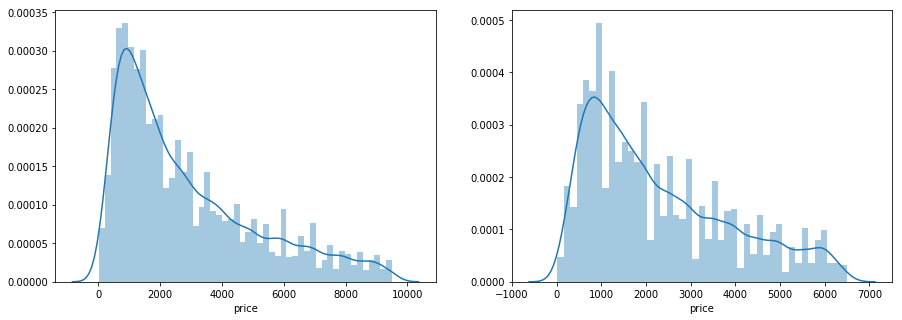

In [12]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])# 去掉尾部10%的数再画一次，依然是呈现长尾分布

从这两个频率分布直方图来看，`price`呈现长尾分布，不利于我们的建模预测，原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。

在这里我们对`train_y`进行了$log(x+1)$变换，使标签贴近于正态分布

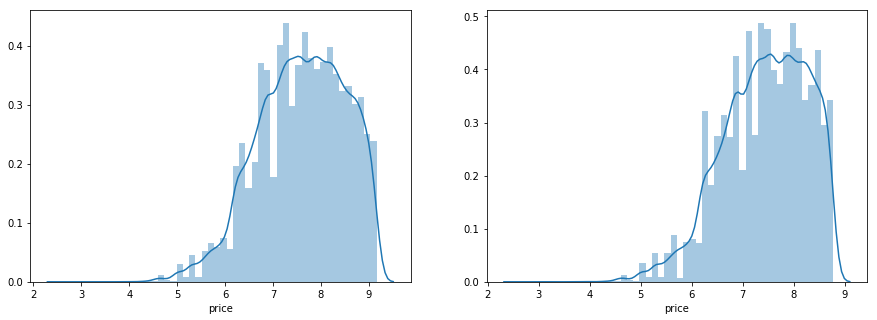

In [13]:
train_y_ln = np.log(train_y + 1)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

可以看出经过对数处理后，长尾分布的效果减弱了。再进行一次线性回归：

In [14]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:22.237755141260187


[('v_1', 5.669305855573455),
 ('v_5', 4.244663233260515),
 ('v_12', 1.2018270333465797),
 ('v_13', 1.1021805892566767),
 ('v_10', 0.9251453991435046),
 ('v_2', 0.8276319426702504),
 ('v_9', 0.6011701859510072),
 ('v_3', 0.4096252333799574),
 ('v_0', 0.08579322268709569),
 ('power_bin', 0.013581489882378468),
 ('bodyType', 0.007405158753814581),
 ('power', 0.0003639122482301998),
 ('brand_price_median', 0.0001295023112073966),
 ('brand_price_max', 5.681812615719255e-05),
 ('brand_price_std', 4.2637652140444604e-05),
 ('brand_price_sum', 2.215129563552113e-09),
 ('gearbox', 7.094911325111752e-10),
 ('seller', 2.715054847612919e-10),
 ('offerType', 1.0291500984749291e-10),
 ('train', -2.2282620193436742e-11),
 ('SaleID', -3.7349069125800904e-09),
 ('name', -6.100613320903764e-08),
 ('brand_amount', -1.63362003323235e-07),
 ('used_time', -2.9274637535648837e-05),
 ('brand_price_min', -2.97497751376125e-05),
 ('brand_price_average', -0.0001181124521449396),
 ('fuelType', -0.0018817210167693

再一次画出预测与真实值的散点对比图：

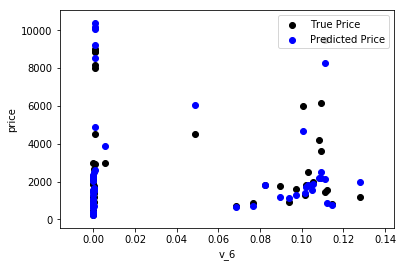

In [15]:
plt.scatter(train_X['v_6'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_6'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_6')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
plt.show()

效果稍微好了一点，但毕竟是线性回归，拟合得还是不够好。

# 3️⃣ 五折交叉验证¶（`cross_val_score`）
&emsp;&emsp;在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（`train_set`），评估集（`valid_set`），测试集（`test_set`）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

&emsp;&emsp;因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（`Cross Validation`）。

&emsp;&emsp;直观的类比就是训练集是上课，评估集是平时的作业，而测试集是最后的期末考试。😏

`Cross Validation`：简言之，就是进行多次`train_test_split`划分；每次划分时，在不同的数据集上进行训练、测试评估，从而得出一个评价结果；如果是5折交叉验证，意思就是在原始数据集上，进行5次划分，每次划分进行一次训练、评估，最后得到5次划分后的评估结果，一般在这几次评估结果上取平均得到最后的评分。`k-fold cross-validation` ，其中，`k`一般取5或10。

一般情况将K折交叉验证用于模型调优，找到使得模型泛化性能最优的超参值。找到后，在全部训练集上重新训练模型，并使用独立测试集对模型性能做出最终评价。K折交叉验证使用了无重复抽样技术的好处：每次迭代过程中每个样本点只有一次被划入训练集或测试集的机会。

![](https://upload-images.jianshu.io/upload_images/9637742-c333f1ad48a0811a.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)
![](https://img-blog.csdn.net/20180205102310918?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvQ2hlblZhc3Q=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)
![](https://img-blog.csdn.net/20180205102314995?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvQ2hlblZhc3Q=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast)


更多参考资料：[几种交叉验证（cross validation）方式的比较
](https://www.cnblogs.com/ysugyl/p/8707887.html)、[k折交叉验证](https://blog.csdn.net/tianguiyuyu/article/details/80697223)


- 下面调用`sklearn.model_selection`的`cross_val_score`进行交叉验证

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

## 3️⃣.1️⃣ `cross_val_score`相应函数的应用

In [17]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

- 上面的`log_transfer`是提供装饰器功能，是为了将下面的`cross_val_score`的`make_scorer`的`mean_absolute_error`（它的公式在下面）的输入参数做对数处理，其中`np.nan_to_num`顺便将`nan`转变为0。
$$
MAE=\frac{\sum\limits_{i=1}^{n}\left|y_{i}-\hat{y}_{i}\right|}{n}
$$
- `cross_val_score`是`sklearn`用于交叉验证评估分数的函数，前面几个参数很明朗，后面几个参数需要解释一下。
    - `verbose`：详细程度，也就是是否输出进度信息
    - `cv`：交叉验证生成器或可迭代的次数
    - `scoring`：调用用来评价的方法，是score越大约好，还是loss越小越好，默认是loss。这里调用了`mean_absolute_error`，只是在调用之前先进行了`log_transfer`的装饰，然后调用的`y`和`yhat`，会自动将`cross_val_score`得到的`X`和`y`代入。
        - `make_scorer`：构建一个完整的定制scorer函数，可选参数`greater_is_better`，默认为`False`，也就是loss越小越好

- 下面是对未进行对数处理的原特征数据进行五折交叉验证

In [18]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [19]:
print('AVG:', np.mean(scores))

AVG: 0.7533845471636889


In [20]:
scores = pd.DataFrame(scores.reshape(1,-1)) # 转化成一行，(-1,1)为一列
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.727867,0.759451,0.781238,0.750681,0.747686


使用线性回归模型，对进行过对数处理的原特征数据进行五折交叉验证

In [21]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [22]:
print('AVG:', np.mean(scores))

AVG: 0.2124134663602803


In [23]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.208238,0.212408,0.215933,0.210742,0.214747


可以看出进行对数处理后，五折交叉验证的loss显著降低。

## 3️⃣.2️⃣ 考虑真实世界限制
&emsp;&emsp;例如：通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大。

In [24]:
import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'])
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'])

In [25]:
model = model.fit(train_X, train_y_ln)

In [26]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.21498301182417004

## 3️⃣.3️⃣ 绘制学习率曲线与验证曲线¶

&emsp;&emsp;学习曲线是一种用来判断训练模型的一种方法，它会自动把训练样本的数量按照预定的规则逐渐增加，然后画出不同训练样本数量时的模型准确度。

&emsp;&emsp;我们可以把$J_{train}(\theta)$和$J_{test}(\theta)$作为纵坐标，画出与训练集数据集$m$的大小关系，这就是学习曲线。通过学习曲线，可以直观地观察到模型的准确性和训练数据大小的关系。 我们可以比较直观的了解到我们的模型处于一个什么样的状态，如：过拟合（overfitting）或欠拟合（underfitting）

&emsp;&emsp;如果数据集的大小为$m$，则通过下面的流程即可画出学习曲线：

- 1.把数据集分成训练数据集和交叉验证集（可以看作测试集）；

- 2.取训练数据集的20%作为训练样本，训练出模型参数；

- 3.使用交叉验证集来计算训练出来的模型的准确性；

- 4.以训练集的score和交叉验证集score为纵坐标(这里的score取决于你使用的`make_score`方法，例如MAE)，训练集的个数作为横坐标，在坐标轴上画出上述步骤计算出来的模型准确性；

- 5.训练数据集增加10%，调到步骤2，继续执行，知道训练数据集大小为100%。

`learning_curve()`：这个函数主要是用来判断（可视化）模型是否过拟合的。下面是一些参数的解释：

- `X`：是一个m*n的矩阵，m:数据数量，n:特征数量；
- `y`：是一个m*1的矩阵，m:数据数量，相对于`X`的目标进行分类或回归；
- `groups`：将数据集拆分为训练/测试集时使用的样本的标签分组。**[可选]**；
- `train_sizes`：指定训练样品数量的变化规则。比如：np.linspace(0.1, 1.0, 5)表示把训练样品数量从0.1-1分成5等分，生成[0.1, 0.325,0.55,0.75,1]的序列，从序列中取出训练样品数量百分比，逐个计算在当前训练样本数量情况下训练出来的模型准确性。
- `cv`：`None`，要使用默认的三折交叉验证（v0.22版本中将改为五折）；
- `n_jobs`：要并行运行的作业数。None表示1。 -1表示使用所有处理器；
- `pre_dispatch`：并行执行的预调度作业数（默认为全部）。该选项可以减少分配的内存。该字符串可以是“ 2 * n_jobs”之类的表达式；
- `shuffle`：`bool`，是否在基于`train_sizes`为前缀之前对训练数据进行洗牌；

In [27]:
from sklearn.model_selection import learning_curve, validation_curve

`plt.fill_between()`用来填充两条线间区域，其他好像没什么好解释的了。

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'D:\\Software\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

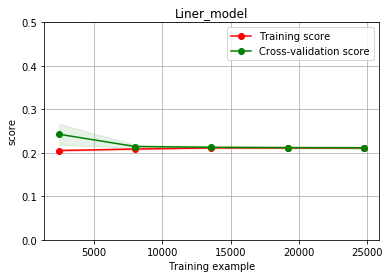

In [29]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:], train_y_ln[:], ylim=(0.0, 0.5), cv=5, n_jobs=-1)  

训练误差与验证误差逐渐一致，准确率也挺高（这里的score是MAE，所以是loss趋近于0.2，准确率趋近于0.8），但是训练误差几乎没变过，所以属于过拟合。这里给出一下高偏差欠拟合(bias)以及高方差过拟合(variance)的模样：

![](https://img-blog.csdn.net/20180909113753737?watermark/2/text/aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM2NTIzODM5/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70)

![](https://pic2.zhimg.com/80/afa034d52962681db09b4dc1060f8075_720w.jpg)

更形象一点：

Data：

![](https://pic2.zhimg.com/80/be0d4d438c4e4875d52ba3eadead68f3_720w.jpg)

Normal fitting:

![](https://pic3.zhimg.com/80/a093710f99364185662a4de1eeaa1573_720w.jpg)

overfitting:

![](https://pic4.zhimg.com/80/a465a986178732b5b7e174b01836f84b_720w.jpg)

serious overfitting:

![](https://pic4.zhimg.com/80/f2cb9fd7683d35bf290d57e2adc00f31_720w.jpg)

# 4️⃣ 多种模型对比

In [31]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

## 4️⃣.1️⃣ 线性模型 & 嵌入式特征选择
&emsp;&emsp;有一些前叙知识需要补全。其中关于正则化的知识：
- 分别为L1正则化与L2正则化；
- L1正则化的模型建叫做Lasso回归，使用L2正则化的模型叫做Ridge回归（岭回归）；
- L1正则化是指权值向量w中各个元素的绝对值之和，通常表示为$\left \| w \right \| _{1} $；
- L2正则化是指权值向量w中各个元素的平方和然后再求平方根（可以看到Ridge回归的L2正则化项有平方符号），通常表示为$\left \| w \right \| _{2} $
- L1正则化可以产生稀疏权值矩阵，即产生一个稀疏模型，可以用于特征选择；
- L2正则化可以防止模型过拟合（overfitting），一定程度上，L1也可以防止过拟合；

更多其他知识可以看这篇文章：[机器学习中正则化项L1和L2的直观理解](https://blog.csdn.net/jinping_shi/article/details/52433975)

&emsp;&emsp;在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。

### 4️⃣.1️⃣.1️⃣ `LinearRegression`，`Ridge`，`Lasso`方法的运行

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [33]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [34]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished


D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Lasso is finished


D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### 4️⃣.1️⃣.2️⃣ 三种方法的对比

In [35]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.208238,0.213319,0.394868
cv2,0.212408,0.216857,0.387564
cv3,0.215933,0.220840,0.402278
cv4,0.210742,0.215001,0.396664
cv5,0.214747,0.220031,0.397400


1.纯`LinearRegression`方法的情况：`.intercept_`是截距（与y轴的交点）即$\theta_0$，`.coef_`是模型的斜率即$\theta_1 - \theta_n$

intercept:22.23769348625359


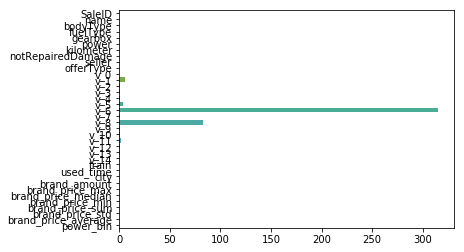

In [36]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_)) # 截距（与y轴的交点）
sns.barplot(abs(model.coef_), continuous_feature_names) 

纯`LinearRegression`回归可以发现，得到的参数列表是比较稀疏的。

In [37]:
model.coef_

array([-3.73489972e-09, -6.10060860e-08,  7.40515349e-03, -1.88182450e-03,
       -1.24570527e-04,  3.63911807e-04, -3.32722751e-02, -2.75710825e-01,
       -1.43048695e-03, -3.28514719e-03,  8.57926933e-02,  5.66930260e+00,
        8.27635812e-01,  4.09620867e-01, -6.72467882e-01,  4.24497013e+00,
       -3.15038152e+02, -1.17801777e+00, -8.30861129e+01,  6.01215351e-01,
        9.25141289e-01, -1.32345773e+00,  1.20182089e+00,  1.10218030e+00,
       -2.59470516e-02,  8.88178420e-13, -2.92746484e-05, -3.63331132e-03,
       -1.63354329e-07,  5.68181101e-05,  1.29502381e-04, -2.97497182e-05,
        2.21512681e-09,  4.26377388e-05, -1.18112552e-04,  1.35814944e-02])

2.`Lasso`方法即L1正则化的情况：

intercept:7.946156528722565


D:\Software\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


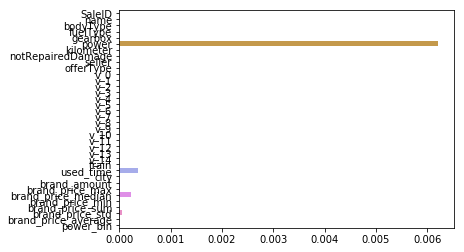

In [40]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如上图，我们发现power与userd_time特征非常重要。

3.`Ridge`方法即L2正则化的情况：

intercept:2.7820015512913994


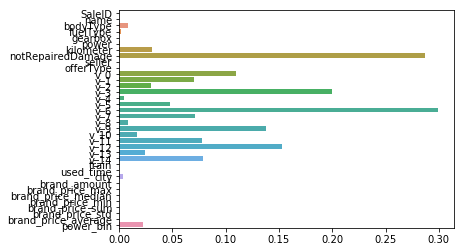

In [38]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

从上图可以看到有很多参数离0较远，很多为0。

原因在于L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。

可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的

## 4️⃣.2️⃣ 非线性模型
&emsp;&emsp;支持向量机，决策树，随机森林，梯度提升树(GBDT)，多层感知机(MLP)，XGBoost，LightGBM等

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

定义模型集合

In [43]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

用数据一一对模型进行训练

In [44]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [46]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.208238,0.224863,0.163196,0.179385,581.596878,0.155881,0.153942
cv2,0.212408,0.218795,0.164292,0.183759,182.180288,0.158566,0.160262
cv3,0.215933,0.216482,0.164849,0.185005,250.668763,0.158520,0.159943
cv4,0.210742,0.220903,0.160878,0.181660,139.101476,0.156608,0.157528
cv5,0.214747,0.226087,0.164713,0.183704,108.664261,0.173250,0.157149


可以看到随机森林模型在每一个fold中均取得了更好的效果

In [73]:
np.mean(result['RandomForestRegressor'])

0.16358568277026037

## 4️⃣.3️⃣ 模型调参

&emsp;&emsp;三种常用的调参方法如下：

贪心算法 https://www.jianshu.com/p/ab89df9759c8<br>
网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029<br>
贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154<br>

In [49]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

### 4️⃣.3️⃣.1️⃣ 贪心调参

In [50]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

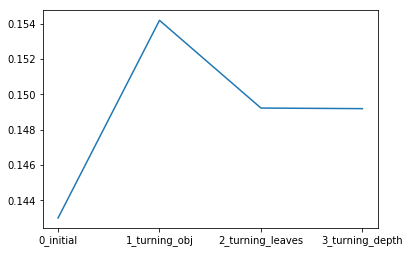

In [54]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

### 4️⃣.3️⃣.2️⃣ Grid Search 网格调参

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [57]:
clf.best_params_

{'max_depth': 10, 'num_leaves': 55, 'objective': 'regression'}

In [59]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=10)

In [60]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.1526351038235066

### 4️⃣.3️⃣.3️⃣ 贝叶斯调参

In [63]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple bayesian-optimization
from bayes_opt import BayesianOptimization

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [65]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val # 贝叶斯调参目标是求最大值，所以用1减去误差

In [66]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [67]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8493   |  80.61    |  97.58    |  44.92    |  0.881    |
|  2        |  0.8514   |  35.87    |  66.92    |  57.68    |  0.7878   |
|  3        |  0.8522   |  49.75    |  68.95    |  64.99    |  0.1726   |
|  4        |  0.8504   |  35.58    |  10.83    |  53.8     |  0.1306   |
|  5        |  0.7942   |  63.37    |  32.21    |  3.143    |  0.4555   |
|  6        |  0.7997   |  2.437    |  4.362    |  97.26    |  0.9957   |
|  7        |  0.8526   |  47.85    |  69.39    |  68.02    |  0.8833   |
|  8        |  0.8537   |  96.87    |  4.285    |  99.53    |  0.9389   |
|  9        |  0.8546   |  96.06    |  97.85    |  98.82    |  0.8874   |
|  10       |  0.7942   |  8.165    |  99.06    |  3.93     |  0.2049   |
|  11       |  0.7993   |  2.77     |  99.47    |  91.16    |  0.2523   |
|  12       |  0.852    |  99.3     | 

In [69]:
rf_bo.max

{'target': 0.8545792238909576,
 'params': {'max_depth': 75.80893509302794,
  'min_child_samples': 61.62267920507557,
  'num_leaves': 99.77501502667806,
  'subsample': 0.9955706357612557}}

In [70]:
1 - rf_bo.max['target']

0.14542077610904236

# 5️⃣ 总结
&emsp;&emsp;在本章中，我们完成了建模与调参的工作，并对我们的模型进行了验证。此外，我们还采用了一些基本方法来提高预测的精度，提升如下图所示。

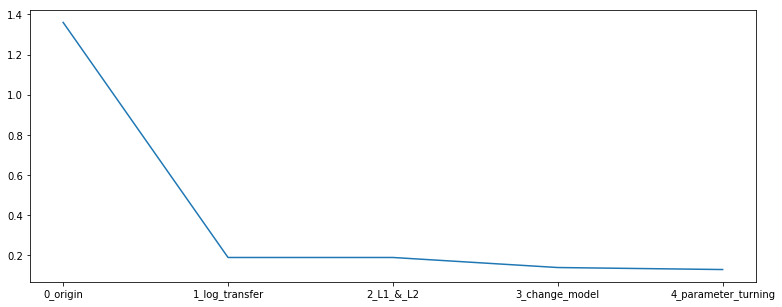

In [71]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.16, 0.15])